##Download data and trained model

In [1]:
!git clone https://github.com/nyoki-mtl/keras-facenet.git

Cloning into 'keras-facenet'...
remote: Enumerating objects: 57, done.
remote: Total 57 (delta 0), reused 0 (delta 0), pack-reused 57
Unpacking objects: 100% (57/57), done.


In [2]:
%cd keras-facenet
%pwd

/content/keras-facenet


'/content/keras-facenet'

In [0]:
%mkdir model/keras/
%mkdir model/keras/model

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/ai_data_colab2/facenet_keras.h5 \
    -O model/keras/model/facenet_keras.h5
#https://storage.googleapis.com/ai_data_colab/facenet_keras_weights.h5

--2020-05-19 07:55:57--  https://storage.googleapis.com/ai_data_colab2/facenet_keras.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 2404:6800:4008:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92397640 (88M) [application/octet-stream]
Saving to: ‘model/keras/model/facenet_keras.h5’

model/keras/model/f 100%[===================>]  88.12M   184MB/s    in 0.5s    

2020-05-19 07:55:58 (184 MB/s) - ‘model/keras/model/facenet_keras.h5’ saved [92397640/92397640]



##Set TensorFlow version and import libraries

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from keras.models import load_model

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


##Set parameters and load the model

In [0]:
cascade_path = 'model/cv2/haarcascade_frontalface_alt2.xml'

image_dir_basepath = 'data/images/'
names = ['LarryPage', 'MarkZuckerberg', 'BillGates']
image_size = 160

model_path = 'model/keras/model/facenet_keras.h5'
model = load_model(model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


##Utils

In [0]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

def load_and_align_images(filepaths, margin):
    cascade = cv2.CascadeClassifier(cascade_path)
    
    aligned_images = []
    for filepath in filepaths:
        img = imread(filepath)

        faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=3)
        (x, y, w, h) = faces[0]
        cropped = img[y-margin//2:y+h+margin//2,
                      x-margin//2:x+w+margin//2, :]
        aligned = resize(cropped, (image_size, image_size), mode='reflect')
        aligned_images.append(aligned)
            
    return np.array(aligned_images)

def calc_embs(filepaths, margin=10, batch_size=1):
    aligned_images = prewhiten(load_and_align_images(filepaths, margin))
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

def calc_dist(img_name0, img_name1):
    return distance.euclidean(data[img_name0]['emb'], data[img_name1]['emb'])

def calc_dist_plot(img_name0, img_name1):
    print(calc_dist(img_name0, img_name1))
    plt.subplot(1, 2, 1)
    plt.imshow(imread(data[img_name0]['image_filepath']))
    plt.subplot(1, 2, 2)
    plt.imshow(imread(data[img_name1]['image_filepath']))

# def train(dir_basepath, names, max_num_img=10):
#     labels = []
#     embs = []
#     for name in names:
#         dirpath = os.path.abspath(dir_basepath + name)
#         filepaths = [os.path.join(dirpath, f) for f in os.listdir(dirpath)][:max_num_img]
#         embs_ = calc_embs(filepaths)    
#         labels.extend([name] * len(embs_))
#         embs.append(embs_)
        
#     embs = np.concatenate(embs)
#     le = LabelEncoder().fit(labels)
#     y = le.transform(labels)
#     clf = SVC(kernel='linear', probability=True).fit(embs, y)
#     return le, clf

# def infer(le, clf, filepaths):
#     embs = calc_embs(filepaths)
#     pred = le.inverse_transform(clf.predict(embs))
#     return pred

##Face embeddings

In [0]:
data = {}
for name in names:
    image_dirpath = image_dir_basepath + name
    image_filepaths = [os.path.join(image_dirpath, f) for f in os.listdir(image_dirpath)]
    embs = calc_embs(image_filepaths)
    for i in range(len(image_filepaths)):
        data['{}{}'.format(name, i)] = {'image_filepath' : image_filepaths[i],
                                        'emb' : embs[i]}

In [0]:
print("dimension of the embedding", len(data['BillGates0']['emb']))
print(data['BillGates0']['emb'])

dimension of the embedding 128
[-1.32754862e-01  2.39620954e-02 -3.99852470e-02  1.40571743e-02
 -3.42714740e-03  1.31454140e-01 -6.74014837e-02  6.37528598e-02
  7.17186481e-02 -1.62141249e-01 -7.47436797e-03  1.23726698e-02
 -5.66100813e-02  1.66914999e-01 -3.30661871e-02  3.89017351e-02
 -6.32883655e-03  2.64717210e-02 -2.94909943e-02  1.80424705e-01
  1.60510942e-01 -1.03214033e-01 -3.05808708e-03 -6.95186704e-02
 -8.96282643e-02 -3.81399728e-02 -1.04114950e-01 -6.15561940e-02
  6.50030375e-02  3.79236750e-02 -2.01640036e-02  8.99899900e-02
 -1.02834664e-01  9.19566974e-02 -7.06050918e-02 -5.67821823e-02
 -8.44099373e-02  1.13249309e-02  1.17667422e-01 -2.34076940e-02
  1.98624820e-01 -7.45040923e-02 -7.64863640e-02 -4.07022238e-02
 -6.32581636e-02 -1.08695969e-01  9.49161723e-02 -1.66483492e-01
  1.51174534e-02 -1.38521697e-02 -1.43506244e-01  1.46955818e-01
  3.83747853e-02 -1.10491537e-01 -6.33596396e-03 -2.75522973e-02
  1.43922687e-01  2.86275484e-02  1.14995964e-01  4.5372277

1.371488094329834


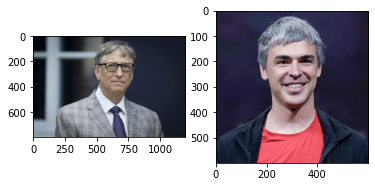

In [0]:
calc_dist_plot('BillGates0', 'LarryPage0')

0.4924261271953583


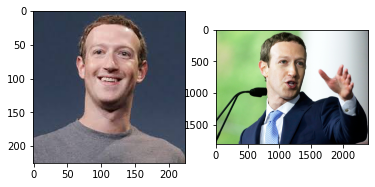

In [0]:
calc_dist_plot('MarkZuckerberg0', 'MarkZuckerberg1')

##plot embeddings

In [0]:
X = []
for v in data.values():
    X.append(v['emb'])
pca = PCA(n_components=3).fit(X)

In [0]:
X_BillGates = []
X_LarryPage = []
X_MarkZuckerberg = []
for k, v in data.items():
    if 'Bill' in k:
        X_BillGates.append(v['emb'])
    elif 'Larry' in k:
        X_LarryPage.append(v['emb'])
    elif 'Mark' in k:
        X_MarkZuckerberg.append(v['emb'])
        
Xd_BillGates = pca.transform(X_BillGates)
Xd_LarryPage = pca.transform(X_LarryPage)
Xd_MarkZuckerberg = pca.transform(X_MarkZuckerberg)

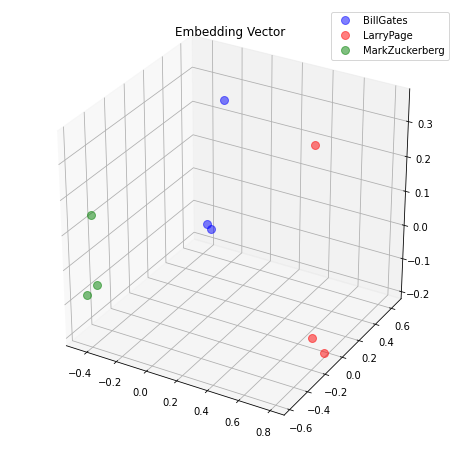

In [0]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(Xd_BillGates[:,0], Xd_BillGates[:,1], Xd_BillGates[:,2],
        'o', markersize=8, color='blue', alpha=0.5, label='BillGates')
ax.plot(Xd_LarryPage[:,0], Xd_LarryPage[:,1], Xd_LarryPage[:,2],
        'o', markersize=8, color='red', alpha=0.5, label='LarryPage')
ax.plot(Xd_MarkZuckerberg[:,0], Xd_MarkZuckerberg[:,1], Xd_MarkZuckerberg[:,2],
        'o', markersize=8, color='green', alpha=0.5, label='MarkZuckerberg')

plt.title('Embedding Vector')
ax.legend(loc='upper right')

plt.show()

##Face Verification (1:1)

In [0]:
#generate the baseline embeddings
data = {}

for name in names:
    image_dirpath = image_dir_basepath + name
    image_filepaths = [os.path.join(image_dirpath, f) for f in os.listdir(image_dirpath)]
    embs = calc_embs(image_filepaths)
    data['{}'.format(name)] = {'image_filepath' : image_filepaths[0], 'emb' : embs[0]}

print(data)

{'LarryPage': {'image_filepath': 'data/images/LarryPage/Larry_Page_0001.jpg', 'emb': array([-1.09796301e-01,  5.89184090e-02,  2.70447209e-02,  6.48752376e-02,
       -3.57579701e-02,  5.67478389e-02,  3.20983730e-04, -1.09974205e-01,
       -1.03241829e-02, -6.08052835e-02,  7.43172914e-02, -5.79896830e-02,
       -1.77723274e-01, -5.74377030e-02, -1.19501606e-01,  4.49780338e-02,
       -5.19061908e-02, -6.22876585e-02, -1.38303071e-01,  5.64723164e-02,
       -3.32997628e-02,  2.61373469e-04, -2.92718224e-02,  5.07796258e-02,
       -2.93041882e-03,  1.15130417e-01,  2.54983716e-02, -1.50240570e-01,
       -4.35636826e-02, -6.34596124e-02,  2.86679342e-02, -5.28964065e-02,
       -1.46520764e-01,  2.96302028e-02,  2.42355536e-03,  1.93410710e-01,
        1.10821716e-01, -1.19798146e-01, -1.90134607e-02,  5.10000139e-02,
        1.83783486e-01, -5.69366328e-02,  2.24493574e-02,  1.43748552e-01,
        7.64197707e-02, -1.07026333e-02,  1.02215946e-01,  5.78843206e-02,
       -1.44663

the target is BillGates, the distance is 0.6540285348892212


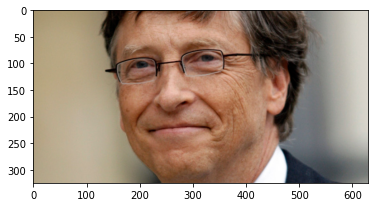

In [0]:
#set the target and base you want to verify
base = 'BillGates'
target = 'test0.jpg'
threshold = 0.8

test_dirpath = os.path.join(image_dir_basepath, 'Test')
test_filepaths = []
test_filepaths.append(os.path.join(test_dirpath, target))
#calculate the target embedding
target_emb = calc_embs(test_filepaths)
predict_dist = distance.euclidean(data[base]['emb'], target_emb)

if predict_dist < threshold:
  print(f"the target is {base}, the distance is {predict_dist}")
else:
  print(f"the target is not {base}, the distance is {predict_dist}")

plt.imshow(imread(test_filepaths[0]))

##Face Recognition (1:N)

it's MarkZuckerberg, the distance is 0.5101137161254883


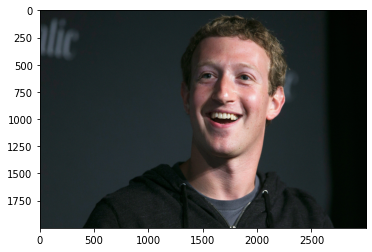

In [0]:
#set the target you want to recognize
target = 'test2.jpg'
threshold = 0.8

test_dirpath = os.path.join(image_dir_basepath, 'Test')
test_filepaths = []
test_filepaths.append(os.path.join(test_dirpath, target))
#calculate the target embedding
target_emb = calc_embs(test_filepaths)
#set the initial value
min_dist = 100

# Loop over the database dictionary's names and embeddings.
for (name, db_emb) in data.items():
  # Compute distance between the target and the current embedding from the database.
  predict_dist = distance.euclidean(db_emb['emb'], target_emb)

  # If this distance is less than the min_dist, then set min_dist to predict_dist, and identity to name.
  if predict_dist < min_dist:
    min_dist = predict_dist
    identity = name
  
if min_dist > threshold:
  print("Unknown, not in the database.")
else:
  print(f"it's {identity}, the distance is {min_dist}")

plt.imshow(imread(test_filepaths[0]))

Reference: https://github.com/nyoki-mtl/keras-facenet